In [1]:
import pandas as pd
import numpy as np

### Data Prep (per day)

In [371]:
path_option = "/Users/apple/PROJECT/supervised-financial-sentiment/market_forecast/data/nvidia/option/nvda_2020_2022.csv"
df = pd.read_csv(path_option)
df.columns = [c.strip().strip('[]').replace(' ', '').upper() for c in df.columns]

# --- parse dates ---
df["QUOTE_DATE"]  = pd.to_datetime(df["QUOTE_DATE"])
df["EXPIRE_DATE"] = pd.to_datetime(df["EXPIRE_DATE"])

# --- cast numeric (many are 'object' strings) ---
num_cols = [
    "UNDERLYING_LAST","DTE","STRIKE","STRIKE_DISTANCE","STRIKE_DISTANCE_PCT",
    "C_IV","P_IV","C_DELTA","P_DELTA","C_BID","C_ASK","P_BID","P_ASK","C_LAST","P_LAST"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        
# --- take last quote of the day per contract (near EOD) ---
df = df.sort_values(["QUOTE_DATE","EXPIRE_DATE","STRIKE","QUOTE_UNIXTIME"])
eod = df.groupby(["QUOTE_DATE","EXPIRE_DATE","STRIKE"], as_index=False).tail(1)

# --- basic quality filters ---
eod["CALL_MID"] = (eod["C_BID"] + eod["C_ASK"]) / 2
eod["PUT_MID"]  = (eod["P_BID"] + eod["P_ASK"]) / 2
eod = eod[
    (eod["C_IV"].between(0.01, 3.0)) &
    (eod["P_IV"].between(0.01, 3.0)) &
    (eod["CALL_MID"] > 0) & (eod["PUT_MID"] > 0) &
    (eod["DTE"].between(5, 365))
].copy()

# optional: drop super-wide spreads
eod["CALL_SPR"] = (eod["C_ASK"] - eod["C_BID"]) / eod["CALL_MID"]
eod["PUT_SPR"]  = (eod["P_ASK"]  - eod["P_BID"])  / eod["PUT_MID"]
eod = eod[(eod["CALL_SPR"] < 0.6) & (eod["PUT_SPR"] < 0.6)]


/var/folders/ls/rcj43y9j0d38d39d28pbbfz40000gn/T/ipykernel_36267/2997327709.py:2: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_option)


### SVI baseline (per-expiry "slice" fit)

#### - Build per-expiry smiles for a given data

In [372]:
def build_smiles_for_date(df_day, r=0.0, q=0.0):
    """
    df_day: rows for a single QUOTE_DATE, must contain
    ['EXPIRE_DATE','STRIKE','UNDERLYING_LAST','C_IV','P_IV','C_BID','C_ASK','P_BID','P_ASK']
    returns: dict { T_in_years: (k_array, iv_array) }
    """
    df_day = df_day.copy()

    # Spot (assume constant across rows for the day)
    S = float(df_day['UNDERLYING_LAST'].iloc[0])

    # Time to expiry in years
    day = pd.to_datetime(df_day['QUOTE_DATE'].iloc[0])
    df_day['T'] = (pd.to_datetime(df_day['EXPIRE_DATE']) - day).dt.days / 365.0
    df_day = df_day[df_day['T'] > 0]

    # Mid quotes (to screen bad data)
    df_day['CALL_MID'] = (pd.to_numeric(df_day['C_BID'], errors='coerce') + 
                        pd.to_numeric(df_day['C_ASK'], errors='coerce'))/2
    df_day['PUT_MID']  = (pd.to_numeric(df_day['P_BID'], errors='coerce') + 
                        pd.to_numeric(df_day['P_ASK'], errors='coerce'))/2

    # Choose OTM vol per strike
    C_IV = pd.to_numeric(df_day['C_IV'], errors='coerce')
    P_IV = pd.to_numeric(df_day['P_IV'], errors='coerce')
    K    = pd.to_numeric(df_day['STRIKE'], errors='coerce')

    iv = np.where(K >= S, C_IV, P_IV).astype(float)

    # Simple forward ≈ S (r≈q≈0 to start). If you prefer, F = S*np.exp((r-q)*T)
    df_day['IV'] = iv
    df_day['k']  = np.log(K / S)

    # Basic quality filters
    df_day = df_day[
        np.isfinite(df_day['IV']) &
        np.isfinite(df_day['k']) &
        (df_day['IV'] > 0.01) & (df_day['IV'] < 3.0) &
        (df_day['CALL_MID'] > 0) & (df_day['PUT_MID'] > 0)
    ].copy()

    # Group by expiry and build slices
    smiles = {}
    for exp, g in df_day.groupby('EXPIRE_DATE'):
        T = float(g['T'].iloc[0])
        k = g['k'].values
        sig = g['IV'].values
        # require enough strikes and some wing coverage
        if len(sig) >= 6 and (np.max(k) - np.min(k) > 0.1):
            smiles[T] = (k, sig)
    return smiles



#### - Fit SVI on one expiry slice

In [373]:
import numpy as np
from scipy.optimize import least_squares

def svi_total_var(k, a, b, rho, m, s0):
    # w(k) = a + b[ rho (k-m) + sqrt((k-m)^2 + s0^2) ]
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + s0**2))

def fit_svi_slice(k, iv, T):
    """
    k: log-moneyness array
    iv: implied vol array (>0)
    T: time to expiry in years (>0)
    returns dict with params and fit diagnostics
    """
    w = (iv**2) * T

    # initial guesses
    k_med = np.median(k)
    span  = np.percentile(k, 90) - np.percentile(k, 10)
    a0    = max(1e-6, np.median(w)*0.5)
    b0    = 0.2
    rho0  = 0.0
    m0    = k_med
    s00   = max(0.1*span, 1e-3)
    x0    = np.array([a0, b0, rho0, m0, s00])

    def resid(x):
        a,b,rho,m,s0 = x
        # simple parameter gates to avoid nonsense
        if (b <= 0) or (s0 <= 0) or (abs(rho) >= 0.999):
            return 1e3*np.ones_like(w)
        w_hat = svi_total_var(k, a,b,rho,m,s0)
        # clamp residuals where w_hat <= 0
        w_hat = np.maximum(w_hat, 1e-10)
        return w_hat - w

    res = least_squares(resid, x0, method="trf", loss="huber", f_scale=0.01, max_nfev=10000)
    a,b,rho,m,s0 = res.x
    return {
        "a":a, "b":b, "rho":rho, "m":m, "s0":s0,
        "success":res.success, "cost":res.cost, "nfev":res.nfev
    }



#### - Fit all slices for a day -> tidy table

In [374]:
def fit_svi_for_day(df, date_str):
    """
    df: full option chain DataFrame
    date_str: 'YYYY-MM-DD' to filter QUOTE_DATE
    returns: DataFrame of SVI params per expiry (T)
    """
    df_day = df[df['QUOTE_DATE'] == date_str].copy()
    if df_day.empty:
        raise ValueError(f"No rows for QUOTE_DATE={date_str}")

    smiles = build_smiles_for_date(df_day)

    rows = []
    for T, (k, iv) in sorted(smiles.items(), key=lambda x: x[0]):
        if T <= 0: 
            continue
        p = fit_svi_slice(k, iv, T)
        print(f"Fitted T={T:.4f} -> {p}")
        if p["success"]:
            rows.append({"date": date_str, "T": T, **{k_: p[k_] for k_ in ["a","b","rho","m","s0"]}, "cost": p["cost"]})
    return pd.DataFrame(rows).sort_values("T")


In [375]:
print(eod.columns)
eod.head()

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'CALL_MID',
       'PUT_MID', 'CALL_SPR', 'PUT_SPR'],
      dtype='object')


,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,CALL_MID,PUT_MID,CALL_SPR,PUT_SPR
747004,1577998800,2020-01-02 16:00,2020-01-02,16.0,239.86,2020-01-10,1578690000,8.0,0.98339,0.00206,...,-0.04018,-0.00059,0.52203,1.000000,37.4,0.156,37.475,0.115,0.052035,0.260870
747005,1577998800,2020-01-02 16:00,2020-01-02,16.0,239.86,2020-01-10,1578690000,8.0,0.99699,0.00066,...,-0.04089,-0.00138,0.49167,21.000000,34.9,0.145,34.875,0.120,0.075986,0.166667
747007,1577998800,2020-01-02 16:00,2020-01-02,16.0,239.86,2020-01-10,1578690000,8.0,0.97172,0.00382,...,-0.05482,-0.00115,0.45308,19.000000,29.9,0.124,30.050,0.175,0.016639,0.171429
747008,1577998800,2020-01-02 16:00,2020-01-02,16.0,239.86,2020-01-10,1578690000,8.0,0.93051,0.00656,...,-0.06291,-0.00158,0.43232,8.000000,27.4,0.114,28.000,0.210,0.075000,0.190476
747009,1577998800,2020-01-02 16:00,2020-01-02,16.0,239.86,2020-01-10,1578690000,8.0,0.95360,0.00609,...,-0.06905,-0.00255,0.40921,88.000000,24.9,0.104,25.175,0.245,0.013903,0.204082


In [376]:
# 0) Load your chain (same file you used for Project C)
# df = pd.read_csv("AAPL_options_raw.csv")

# 1) Normalize column names (optional but helpful)
# df.columns = [c.strip().strip('[]').replace(' ', '').upper() for c in df.columns]

# Ensure these exist (or adapt names):
# QUOTEDATE, EXPIREDATE, STRIKE, UNDERLYINGLAST, C_IV, P_IV, C_BID, C_ASK, P_BID, P_ASK
# If yours are QUOTE_DATE, EXPIRE_DATE, etc., keep as-is (the code above assumes those).

# If needed, rename to the exact keys used above:
# df = df.rename(columns={"QUOTE_DATE":"QUOTE_DATE","EXPIRE_DATE":"EXPIRE_DATE","UNDERLYING_LAST":"UNDERLYING_LAST", ...})

# 2) Pick a day with lots of quotes
one_day = eod['QUOTE_DATE'].iloc[0]  # or a specific date string like "2021-01-04"

# 3) Fit SVI for that day
params_day = fit_svi_for_day(eod, one_day)

# 4) Save for later (you’ll need these for Step 3/4 interpolation & OOS prediction)
params_day.to_csv(f"svi_params_{one_day}.csv", index=False)


Fitted T=0.0219 -> {'a': -0.038497938943694555, 'b': 0.07017313590153731, 'rho': 0.002373485697245977, 'm': -0.003102595236501529, 's0': 0.17138288240725447, 'success': True, 'cost': 0.00012017787795504392, 'nfev': 2}
Fitted T=0.0411 -> {'a': -0.05354559921356925, 'b': 0.04868298576189706, 'rho': 0.007570581575168821, 'm': -0.01800923409246443, 's0': 0.17133697547188878, 'success': True, 'cost': 0.0012440168410408935, 'nfev': 2}
Fitted T=0.0603 -> {'a': -0.0464329466947149, 'b': 0.0528986383339064, 'rho': 0.0012625838956118781, 'm': -0.027578561404870076, 's0': 0.17240244327220433, 'success': True, 'cost': 0.0012987078173760606, 'nfev': 2}
Fitted T=0.0795 -> {'a': -0.04235088387459075, 'b': 0.04448652856825147, 'rho': -0.00032457613107023526, 'm': -0.030336280751062462, 's0': 0.17288466417946707, 'success': True, 'cost': 0.00225054474082202, 'nfev': 2}
Fitted T=0.0986 -> {'a': -0.0191792357305897, 'b': 0.046554367967713395, 'rho': -5.673109747158092e-05, 'm': 0.016708093742299333, 's0'

#### - (Optional) Quick IV Reconstruction Check

In [377]:
def reconstruct_iv(k, T, p):
    w = svi_total_var(k, p["a"], p["b"], p["rho"], p["m"], p["s0"])
    return np.sqrt(np.maximum(w, 1e-12)/T)

# Example sanity check on the first expiry of the day
smiles = build_smiles_for_date(df[df['QUOTE_DATE']==one_day])
T0 = sorted(smiles.keys())[0]
k0, iv0 = smiles[T0]
p0 = params_day.loc[params_day['T'].sub(T0).abs().idxmin(), ["a","b","rho","m","s0"]].to_dict()
iv_fit = reconstruct_iv(k0, T0, p0)

print("MSE on first slice:", np.mean((iv_fit - iv0)**2))


MSE on first slice: 1.0687327285672596


### Interpolate & Evaluate

In [378]:
def interpolate_params(T_query, params_day):
    """
    Interpolates SVI parameters for a given maturity T_query.
    params_day: DataFrame with columns ['T','a','b','rho','m','s0']
    """
    Ts = params_day['T'].values
    if T_query <= Ts.min():
        row = params_day.loc[params_day['T'].idxmin()]
    elif T_query >= Ts.max():
        row = params_day.loc[params_day['T'].idxmax()]
    else:
        # linear interpolation
        i = np.searchsorted(Ts, T_query)
        T1, T2 = Ts[i-1], Ts[i]
        p1 = params_day.iloc[i-1]
        p2 = params_day.iloc[i]
        w = (T_query - T1) / (T2 - T1)
        row = {}
        for col in ['a','b','rho','m','s0']:
            row[col] = (1-w)*p1[col] + w*p2[col]
        row = pd.Series(row)
    return row

def svi_surface_iv(k, T, params_day):
    """
    Compute implied vol for log-moneyness k, maturity T,
    given per-expiry params for one day.
    """
    row = interpolate_params(T, params_day)
    w_tot = svi_total_var(k, row['a'], row['b'], row['rho'], row['m'], row['s0'])
    return np.sqrt(np.maximum(w_tot, 1e-12)/T)


In [ ]:
k_grid = np.linspace(-0.5, 0.5, 25)  # Log-moneyness from -50% to +50%
T = 0.25  # 3 months

# Compute implied volatilities for the k_grid
surface_df = pd.DataFrame({
    "k": k_grid,
    "T": T,
    "IV": [svi_surface_iv(k, T, params_day) for k in k_grid]
})



           k     T        IV
0  -0.500000  0.25  0.472961
1  -0.458333  0.25  0.460089
2  -0.416667  0.25  0.447178
3  -0.375000  0.25  0.434305
4  -0.333333  0.25  0.421579
5  -0.291667  0.25  0.409141
6  -0.250000  0.25  0.397171
7  -0.208333  0.25  0.385878
8  -0.166667  0.25  0.375479
9  -0.125000  0.25  0.366171
10 -0.083333  0.25  0.358086
11 -0.041667  0.25  0.351271
12  0.000000  0.25  0.345683
13  0.041667  0.25  0.341211
14  0.083333  0.25  0.337713
15  0.125000  0.25  0.335036
16  0.166667  0.25  0.333038
17  0.208333  0.25  0.331597
18  0.250000  0.25  0.330610
19  0.291667  0.25  0.329993
20  0.333333  0.25  0.329679
21  0.375000  0.25  0.329615
22  0.416667  0.25  0.329756
23  0.458333  0.25  0.330069
24  0.500000  0.25  0.330524


k_grid: [-0.5        -0.45833333 -0.41666667 -0.375      -0.33333333 -0.29166667
 -0.25       -0.20833333 -0.16666667 -0.125      -0.08333333 -0.04166667
  0.          0.04166667  0.08333333  0.125       0.16666667  0.20833333
  0.25        0.29166667  0.33333333  0.375       0.41666667  0.45833333
  0.5       ]
params_day:
        date         T         a         b       rho         m            s0  \
0 2020-01-02  0.021918 -0.038498  0.070173  0.002373 -0.003103  1.713829e-01   
1 2020-01-02  0.041096 -0.053546  0.048683  0.007571 -0.018009  1.713370e-01   
2 2020-01-02  0.060274 -0.046433  0.052899  0.001263 -0.027579  1.724024e-01   
3 2020-01-02  0.079452 -0.042351  0.044487 -0.000325 -0.030336  1.728847e-01   
4 2020-01-02  0.098630 -0.019179  0.046554 -0.000057  0.016708  1.507589e-01   
5 2020-01-02  0.117808  0.013707  0.026968  0.092704  0.048371  1.562132e-11   
6 2020-01-02  0.136986 -0.043097  0.024609  0.005972  0.022228  1.639963e-01   
7 2020-01-02  0.213699  0.016398  

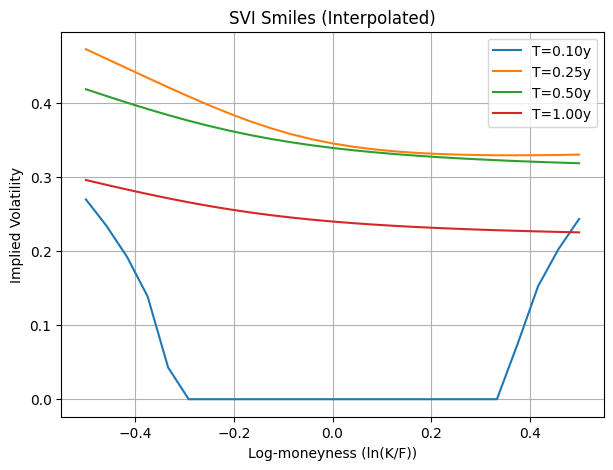

Unique values in k: 25
Unique values in T: 10


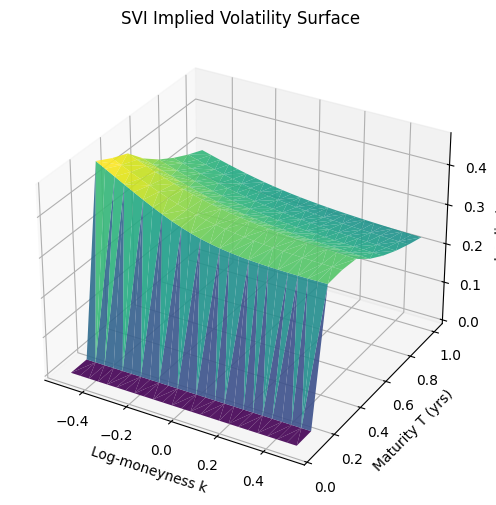

In [385]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Debugging: Check k_grid and params_day
print("k_grid:", k_grid)
print("params_day:")
print(params_day)

# 2D: Smiles for some maturities
plt.figure(figsize=(7, 5))
for T in [0.1, 0.25, 0.5, 1.0]:
    ivs = [svi_surface_iv(k, T, params_day) for k in k_grid]
    plt.plot(k_grid, ivs, label=f"T={T:.2f}y")
plt.xlabel("Log-moneyness (ln(K/F))")
plt.ylabel("Implied Volatility")
plt.title("SVI Smiles (Interpolated)")
plt.legend()
plt.grid(True)
plt.show()

# Ensure k_grid and T_grid are properly defined
k_grid = np.linspace(-0.5, 0.5, 25)  # Log-moneyness from -50% to +50%
T_grid = np.linspace(0.05, 1.0, 10)  # Maturities from ~2 weeks to 1 year

# Evaluate the surface (replace with your actual evaluation function)
surface = []
for T in T_grid:
    for k in k_grid:
        iv = svi_surface_iv(k, T, params_day)  # Replace with your actual function
        surface.append({"T": T, "k": k, "IV": iv})
surface_df = pd.DataFrame(surface)

# Remove duplicate rows
surface_df = surface_df.drop_duplicates()

# Debugging: Check the spread of k and T
print("Unique values in k:", surface_df['k'].nunique())
print("Unique values in T:", surface_df['T'].nunique())

# 3D: Full surface plot
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(surface_df['k'], surface_df['T'], surface_df['IV'], cmap="viridis", alpha=0.9)
ax.set_xlabel("Log-moneyness k")
ax.set_ylabel("Maturity T (yrs)")
ax.set_zlabel("Implied Vol")
ax.set_title("SVI Implied Volatility Surface")
plt.show()

### Add up Earning day then compare a normal day with an earning day

### OOS Prediction

In [199]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

def forecast_param(df, T_target, param="a", tol=0.02):
    """
    Fit AR(1) regression for param on expiry slice closest to T_target.
    Returns fitted model and the closest_T.
    """
    Ts = df["T"].unique()
    closest_T = Ts[np.argmin(np.abs(Ts - T_target))]

    d = df[df["T"].round(3) == round(closest_T, 3)].copy()
    d = d.dropna(subset=[param])

    d = d.sort_values("date").reset_index(drop=True)

    # tomorrow’s value
    y = d[param].shift(-1).reset_index(drop=True)
    
    X = pd.DataFrame({"lag": d[param].values})
    X = sm.add_constant(X)

    mask = ~y.isna()
    res = sm.OLS(y[mask], X[mask]).fit()
    return res, closest_T



In [390]:
svi_param_path = "/Users/apple/PROJECT/supervised-financial-sentiment/market_forecast/data/nvidia/option/svi_params_timeseries_nvda_2020_2022.csv"
svi_df = pd.read_csv(svi_param_path)
svi_df.head()

,date,T,a,b,rho,m,s0,cost
0,2020-01-02,0.021918,-0.038498,0.070173,0.002373,-0.003103,0.171383,0.000120
1,2020-01-02,0.041096,-0.053546,0.048683,0.007571,-0.018009,0.171337,0.001244
2,2020-01-02,0.060274,-0.046433,0.052899,0.001263,-0.027579,0.172402,0.001299
3,2020-01-02,0.079452,-0.042351,0.044487,-0.000325,-0.030336,0.172885,0.002251
4,2020-01-02,0.098630,-0.019179,0.046554,-0.000057,0.016708,0.150759,0.001290


In [391]:
res, closest_T = forecast_param(svi_df, T_target=0.25, param="a")
print(f"Forecasting 'a' for T≈{closest_T:.3f}y")

print(res.summary())


Forecasting 'a' for T≈0.249y
                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.050
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.314
Time:                        12:31:46   Log-Likelihood:                -32.185
No. Observations:                  30   AIC:                             68.37
Df Residuals:                      28   BIC:                             71.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2421  

#### Predict Tmr's surface

In [392]:

def predict_surface(df, T, k_grid, res, today):
    """
    Predict IV surface for given date 'today' and maturity T.
    Forecasts 'a' with AR(1) model, others via persistence.
    """

    # Restrict to today's slice
    df_day = df[df["date"] == today]
    if df_day.empty:
        print(f"No data for {today}")
        return None

    # Find closest maturity
    Ts = df_day["T"].unique()
    closest_T = Ts[np.argmin(np.abs(Ts - T))]

    row_today = df_day[df_day["T"].round(3) == round(closest_T, 3)]
    if row_today.empty:
        print(f"No row for T≈{T} on {today}")
        return None
    print('row_today:', row_today)
    # Predict next-day a using regression res
    X_new = pd.DataFrame({"lag": [row_today["a"].iloc[0]]})
    X_new = sm.add_constant(X_new, has_constant="add")

    a_hat = res.predict(X_new)[0]
    print(f"Predicted a for {today}, T={closest_T:.3f}y: {a_hat:.4f}")

    # Persistence baseline for others
    p = {
        "a": a_hat,
        "b": row_today["b"].iloc[0],
        "rho": row_today["rho"].iloc[0],
        "m": row_today["m"].iloc[0],
        "s0": row_today["s0"].iloc[0]
    }

    # Compute implied vols
    print(f"Using params: {p}")
    w_tot = svi_total_var(k_grid, p["a"], p["b"], p["rho"], p["m"], p["s0"])
    print(w_tot[:10])
    ivs = np.sqrt(np.maximum(w_tot, 1e-12) / closest_T)

    return ivs


row_today:             date         T         a         b       rho         m        s0  \
8489  2022-12-20  0.084932 -1.920538  7.823789 -0.971667 -4.123722  1.049654   

          cost  
8489  0.000019  
Predicted a for 2022-12-20, T=0.085y: -0.6067
Using params: {'a': -0.6066813728313477, 'b': 7.823788746173873, 'rho': -0.9716667836502292, 'm': -4.123721629581099, 's0': 1.0496540322314705}
[1.36203736 1.35854018 1.35531304 1.3523476  1.34963585 1.34717011
 1.34494299 1.34294739 1.34117649 1.33962371]


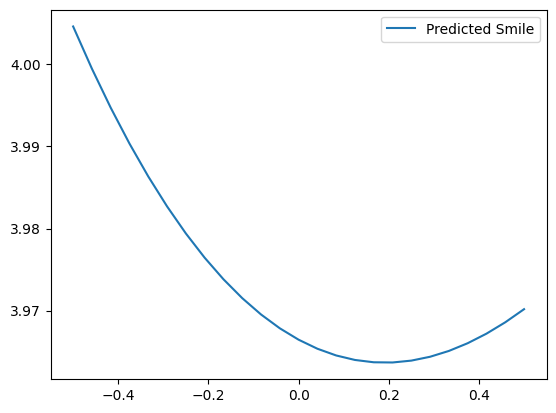

In [393]:
k_grid = np.linspace(-0.5, 0.5, 25)  # log-moneyness grid
today = "2022-12-20"

ivs_pred = predict_surface(svi_df, T=0.08, k_grid=k_grid, res=res, today=today)

plt.plot(k_grid, ivs_pred, label="Predicted Smile")
plt.legend(); plt.show()


#### With Sentiment

In [394]:
def forecast_param_with_sentiment(df, sentiment_df, T_target, param="a", tol=0.02):
    """
    Fit AR(1) regression for param on expiry slice closest to T_target, including sentiment factors.
    Returns fitted model and the closest_T.
    
    Parameters:
        df (pd.DataFrame): Dataframe containing SVI parameters.
        sentiment_df (pd.DataFrame): Dataframe containing sentiment data.
        T_target (float): Target maturity in years.
        param (str): Parameter to forecast (default is 'a').
        tol (float): Tolerance for finding the closest maturity.
    
    Returns:
        res (statsmodels.regression.linear_model.RegressionResults): Fitted AR(1) model.
        closest_T (float): Closest maturity to T_target.
    """
    # Find the closest maturity to T_target
    Ts = df["T"].unique()
    closest_T = Ts[np.argmin(np.abs(Ts - T_target))]

    # Filter data for the closest maturity
    d = df[df["T"].round(3) == round(closest_T, 3)].copy()
    d = d.dropna(subset=[param])

    # Sort by date and reset index
    d = d.sort_values("date").reset_index(drop=True)

    # Merge with sentiment data
    # d = d.merge(sentiment_df, on="date", how="left").dropna()
    # print('d after merge:', d)

    # Tomorrow’s value (dependent variable)
    y = d[param].shift(-1).reset_index(drop=True)
    
    # Explanatory variables (lagged parameter and sentiment factors)
    X = pd.DataFrame({
        "lag": d[param].values,
        "sec_vol": d["sec_vol"].values,
        "sec_vol+1": d["sec_vol+1"].values,
        "calls_vol": d["calls_vol"].values,
        "calls_vol+1": d["calls_vol+1"].values,
        "report_vol": d["report_vol"].values,
        "report_vol+1": d["report_vol+1"].values,
    })
    X = sm.add_constant(X)  # Add constant for the regression
    
    # Mask to exclude rows where y is NaN
    mask = ~y.isna()
    res = sm.OLS(y[mask], X[mask]).fit()  # Fit the AR(1) model with sentiment factors
    return res, closest_T

In [395]:
def predict_surface_with_sentiment(df, T, k_grid, res, today, sentiment_df):
    """
    Predict IV surface for given date 'today' and maturity T, incorporating sentiment factors.
    Forecasts 'a' with AR(1) model and sentiment, others via persistence.
    
    Parameters:
        df (pd.DataFrame): Dataframe containing SVI parameters.
        T (float): Target maturity in years.
        k_grid (np.array): Grid of log-moneyness values for prediction.
        res (statsmodels.regression.linear_model.RegressionResults): Fitted AR(1) model for 'a'.
        today (str): Date for prediction (format: 'YYYY-MM-DD').
        sentiment_df (pd.DataFrame): Dataframe containing sentiment data with columns ['date', 'sec_vol', ...].
    
    Returns:
        np.array: Predicted implied volatilities for the given `k_grid`.
    """

    # Restrict to today's slice
    df_day = df[df["date"] == today]
    if df_day.empty:
        print(f"No data for {today}")
        return None

    # Find closest maturity
    Ts = df_day["T"].unique()
    closest_T = Ts[np.argmin(np.abs(Ts - T))]

    row_today = df_day[df_day["T"].round(3) == round(closest_T, 3)]
    if row_today.empty:
        print(f"No row for T≈{T} on {today}")
        return None

    # Get today's sentiment values
    sentiment_today = sentiment_df[sentiment_df["date"] == today]
    if sentiment_today.empty:
        print(f"No sentiment data for {today}")
        return None

    # Extract sentiment values for today
    sentiment_values = sentiment_today.iloc[0][[
        "sec_vol", "sec_vol+1", "calls_vol", "calls_vol+1", "report_vol", "report_vol+1"
    ]].values

    # Predict next-day 'a' using regression with sentiment
    X_new = pd.DataFrame({
        "lag": [row_today["a"].iloc[0]],
        "sec_vol": [sentiment_values[0]],
        "sec_vol+1": [sentiment_values[1]],
        "calls_vol": [sentiment_values[2]],
        "calls_vol+1": [sentiment_values[3]],
        "report_vol": [sentiment_values[4]],
        "report_vol+1": [sentiment_values[5]],
    })
    X_new = sm.add_constant(X_new, has_constant="add")

    a_hat = res.predict(X_new)[0]
    print(f"Predicted a for {today}, T={closest_T:.3f}y: {a_hat:.4f}")

    # Persistence baseline for other parameters
    p = {
        "a": a_hat,
        "b": row_today["b"].iloc[0],
        "rho": row_today["rho"].iloc[0],
        "m": row_today["m"].iloc[0],
        "s0": row_today["s0"].iloc[0]
    }

    # Compute implied vols
    print(f"Using params: {p}")
    w_tot = svi_total_var(k_grid, p["a"], p["b"], p["rho"], p["m"], p["s0"])
    ivs = np.sqrt(np.maximum(w_tot, 1e-12) / closest_T)

    return ivs

In [396]:
# Data Load
merged_df_path = "/Users/apple/PROJECT/supervised-financial-sentiment/market_forecast/data/nvidia/prediction/merged_data.csv"
merged_df = pd.read_csv(merged_df_path)


drop_column = ['open','close','high','low','volume','div_adj_factor','sec_ret','calls_ret','report_ret','return','sec_ret+1','calls_ret+1','report_ret+1']
sentiment_df = merged_df.drop(columns=drop_column).dropna().reset_index(drop=True)
sentiment_df = sentiment_df.rename(columns={'Date': 'date'})
# print(sentiment_df.head())

# Ensure 'date' columns in both DataFrames are of the same type
svi_df["date"] = pd.to_datetime(svi_df["date"])
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])

# sentiment_df: ['date','sentiment'] scaled e.g. z-score or [-1,1]
svi_df = svi_df.merge(sentiment_df, on="date", how="left").dropna()



In [397]:
# Example usage
res, closest_T = forecast_param_with_sentiment(svi_df, sentiment_df, T_target=0.25, param="a")
print("res:", res.summary())


res:                             OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                 -0.121
Method:                 Least Squares   F-statistic:                    0.5358
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.798
Time:                        12:31:50   Log-Likelihood:                -31.422
No. Observations:                  31   AIC:                             78.84
Df Residuals:                      23   BIC:                             90.32
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1759      0.449     -0.3

In [343]:
ivs_pred = predict_surface_with_sentiment(svi_df, T=0.25, k_grid=np.linspace(-0.2, 0.2, 50), res=res, today="2020-06-19", sentiment_df=sentiment_df)

Predicted a for 2020-06-19, T=0.249y: -0.3621
Using params: {'a': -0.36210106365988587, 'b': 0.0739721285642845, 'rho': -0.4499309060544806, 'm': 0.0769131508440272, 's0': 0.5098902280525132}


In [358]:
print("svi_df", svi_df)


svi_df            date         T         a          b       rho         m        s0  \
0    2020-01-02  0.021918 -0.038498   0.070173  0.002373 -0.003103  0.171383   
1    2020-01-02  0.041096 -0.053546   0.048683  0.007571 -0.018009  0.171337   
2    2020-01-02  0.060274 -0.046433   0.052899  0.001263 -0.027579  0.172402   
3    2020-01-02  0.079452 -0.042351   0.044487 -0.000325 -0.030336  0.172885   
4    2020-01-02  0.098630 -0.019179   0.046554 -0.000057  0.016708  0.150759   
...         ...       ...       ...        ...       ...       ...       ...   
9155 2022-12-30  0.115068 -1.087553   5.842171  0.964655  2.962649  0.725336   
9156 2022-12-30  0.134247 -1.330320  49.007192  0.994986  3.025935  0.278729   
9157 2022-12-30  0.210959 -1.001460  49.874179  0.995456  2.703458  0.223057   
9158 2022-12-30  0.306849 -0.441703   0.821150  0.765188  1.625019  0.982070   
9159 2022-12-30  0.460274 -1.880574  58.736194  0.994633  3.759211  0.328460   

          cost   sec_vol  sec_vo

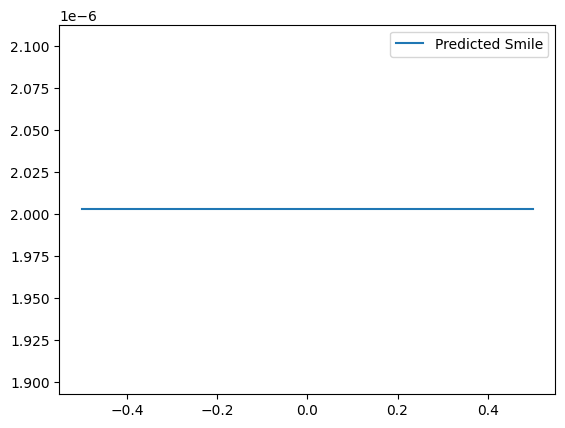

In [344]:
k_grid = np.linspace(-0.5, 0.5, len(ivs_pred))  # log-moneyness grid

plt.plot(k_grid, ivs_pred, label="Predicted Smile")
plt.legend(); plt.show()


### Evaluation

In [359]:
import numpy as np, pandas as pd, statsmodels.api as sm

def _zscore_fit(X_train: pd.DataFrame):
    mu = X_train.mean(axis=0)
    sd = X_train.std(axis=0).replace(0, 1.0)
    return mu, sd

def _zscore_apply(X: pd.DataFrame, mu: pd.Series, sd: pd.Series):
    Xz = (X - mu) / sd
    return Xz.fillna(0.0)


# ---------- SVI ----------
def svi_total_var(k,a,b,rho,m,s):
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + s**2))

def svi_variance(k,a,b,rho,m,s):
    # same formula, but interpreted as σ^2(k), i.e., DO NOT divide by T later
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + s**2))

# ---------- transforms (stability / constraints) ----------
_EPS = 1e-12
def _id(x): return x
def _inv_id(x): return x
def _logp(x): return np.log(np.maximum(x, _EPS))
def _inv_logp(z): return np.exp(z)
def _atanh_clip(x, eps=1e-6): return np.arctanh(np.clip(x, -1+eps, 1-eps))
def _tanh(z): return np.tanh(z)

def tf_for(p):
    if p in ("b","s0"): return _logp, _inv_logp
    if p=="rho":        return _atanh_clip, _tanh
    return _id, _inv_id   # a, m

# ---------- no-arbitrage soft repair ----------
def repair_noarb(a,b,rho,m,s, eps=1e-10):
    # ensure b>0,s>0,|rho|<1 and w_min >= 0
    b = float(max(b, 1e-10))
    s = float(max(s, 1e-10))
    rho = float(np.clip(rho, -0.999, 0.999))
    wmin = a + b*s*np.sqrt(1-rho**2)
    if wmin < eps:
        a = eps - b*s*np.sqrt(1-rho**2)   # minimal tweak to make w_min=eps
    return a,b,rho,m,s

# ---------- helpers ----------
def make_slice(df, T_target):
    Ts = df["T"].unique()
    closest_T = Ts[np.argmin(np.abs(Ts - T_target))]
    d = df[df["T"].round(3)==round(closest_T,3)].copy()
    d = d.sort_values("date").reset_index(drop=True)
    d["date"] = pd.to_datetime(d["date"])
    return d, float(closest_T)

def predict_params_row(row, models):
    pred = {}
    for p, pack in models.items():
        res, (fwd,inv) = pack["res"], pack["tf"]
        x_t = float(row[p])
        xst = fwd(x_t)
        X_new = sm.add_constant(pd.DataFrame({"lag":[xst], **pack.get("x_exo0",{})}), has_constant="add")
        xhat = inv(float(res.predict(X_new)[0]))
        # guards
        if p in ("b","s0"): xhat = max(xhat, 1e-8)
        if p=="rho": xhat = float(np.clip(xhat, -0.999, 0.999))
        pred[p]=xhat
    # soft no-arb
    pred["a"],pred["b"],pred["rho"],pred["m"],pred["s0"] = repair_noarb(
        pred["a"],pred["b"],pred["rho"],pred["m"],pred["s0"])
    return pred

def iv_from_params(k, params, T_used, mode):
    if mode=="total":
        w = svi_total_var(k, params["a"], params["b"], params["rho"], params["m"], params["s0"])
        w = np.maximum(w, 1e-12)
        return np.sqrt(w / max(T_used, 1e-6))
    else:  # "variance"
        s2 = svi_variance(k, params["a"], params["b"], params["rho"], params["m"], params["s0"])
        s2 = np.maximum(s2, 1e-12)
        return np.sqrt(s2)

# ---------- fitters ----------
def fit_baseline_models(d, exo_cols=None):
    # AR(1): y*_{t+1} ~ const + y*_{t}
    models={}
    for p in ["a","b","rho","m","s0"]:
        fwd,inv = tf_for(p)
        y = fwd(d[p].astype(float).values)
        y_next = pd.Series(y).shift(-1)
        X = pd.DataFrame({"lag":y})
        if exo_cols:  # allow same interface but ignore exo in baseline
            pass
        X = sm.add_constant(X)
        mask = ~y_next.isna()
        res = sm.OLS(y_next[mask], X.loc[mask]).fit()
        models[p]={"res":res,"tf":(fwd,inv)}
    return models
def fit_sentiment_models(d, exo_cols, allow_plus1=False):
    """
    ARX(1): y*_{t+1} ~ const + y*_{t} + exo_t  (exo standardized on train window later)
    Returns per-parameter OLS model + transforms + exo mux/sigmas for scaling a single row at predict-time.
    """
    # (we z-score inside backtest per training window; this function just defines the structure)
    models={}
    for p in ["a","b","rho","m","s0"]:
        fwd,inv = tf_for(p)
        y = fwd(d[p].astype(float).values)
        y_next = pd.Series(y).shift(-1)

        # choose exo columns (drop +1 to be safe unless explicitly allowed)
        cols = [c for c in exo_cols if allow_plus1 or ("+1" not in c)]
        X = pd.DataFrame({"lag": y}, index=d.index)
        for c in cols:
            X[c] = d[c].astype(float).values

        # NOTE: NO scaling here; we’ll scale per training window inside backtest
        X = sm.add_constant(X)
        mask = ~y_next.isna() & ~np.isnan(X.values).any(axis=1)
        if mask.sum() < 10:
            # fallback to AR(1) only if too few observations with exo
            X_fallback = sm.add_constant(pd.DataFrame({"lag":y}))
            res = sm.OLS(y_next[~y_next.isna()], X_fallback.loc[~y_next.isna()]).fit()
            models[p]={"res":res,"tf":(fwd,inv),"exo_cols":[],"mu":None,"sd":None}
        else:
            # temporary fit; real fit with scaling happens in backtest loop
            res = sm.OLS(y_next[mask], X.loc[mask]).fit()
            models[p]={"res":res,"tf":(fwd,inv),"exo_cols":cols,"mu":None,"sd":None}
    return models

def fit_sentiment_models_trainwindow(train, exo_cols, allow_plus1=False):
    """
    Same as above, but actually z-scores exogenous features using train window statistics.
    """
    models={}
    cols = [c for c in exo_cols if allow_plus1 or ("+1" not in c)]
    for p in ["a","b","rho","m","s0"]:
        fwd,inv = tf_for(p)
        y = fwd(train[p].astype(float).values)
        y_next = pd.Series(y).shift(-1)

        X = pd.DataFrame({"lag": y}, index=train.index)
        for c in cols:
            X[c] = train[c].astype(float).values

        # z-score exo on training window
        exo = X[cols] if cols else pd.DataFrame(index=train.index)
        if cols:
            mu, sd = _zscore_fit(exo)
            X[cols] = _zscore_apply(exo, mu, sd)
        else:
            mu, sd = None, None

        X = sm.add_constant(X)
        mask = ~y_next.isna() & ~np.isnan(X.values).any(axis=1)
        res = sm.OLS(y_next[mask], X.loc[mask]).fit()
        models[p]={"res":res,"tf":(fwd,inv),"exo_cols":cols,"mu":mu,"sd":sd}
    return models
def predict_params_row_with_exo(row, models):
    """
    Predict next-day params from today's row using fitted ARX models.
    """
    pred = {}
    for p, pack in models.items():
        res, (fwd,inv) = pack["res"], pack["tf"]
        cols, mu, sd   = pack["exo_cols"], pack["mu"], pack["sd"]

        x_t = float(row[p])
        xst = fwd(x_t)

        X_new = pd.DataFrame({"lag":[xst]})
        # add exogenous features (z-scored with train mu/sd)
        if cols:
            exo_row = pd.DataFrame({c: [float(row[c])] for c in cols})
            exo_z = _zscore_apply(exo_row, mu, sd)
            for c in cols:
                X_new[c] = exo_z[c].iloc[0]
        X_new = sm.add_constant(X_new, has_constant="add")

        xhat = inv(float(res.predict(X_new)[0]))
        if p in ("b","s0"): xhat = max(xhat, 1e-8)
        if p=="rho": xhat = float(np.clip(xhat, -0.999, 0.999))
        pred[p]=xhat

    pred["a"],pred["b"],pred["rho"],pred["m"],pred["s0"] = repair_noarb(
        pred["a"],pred["b"],pred["rho"],pred["m"],pred["s0"])
    return pred

# ---------- backtest ----------


def backtest_compare_multisent(df, T_target, exo_cols, k_grid, mode="variance",
                               train_end=None, expanding=True, allow_plus1=False):
    d, T_used = make_slice(df, T_target)
    if train_end is None:
        split_idx = int(0.7*len(d))
        cutoff = d.loc[split_idx,"date"]
    else:
        cutoff = pd.to_datetime(train_end)

    errs_base, errs_sent, dates = [], [], []
    for t in range(1, len(d)-1):
        if d.loc[t,"date"] < cutoff: 
            continue

        train = d.iloc[:t].copy() if expanding else d.iloc[max(0,t-250):t].copy()
        test_t      = d.iloc[t].copy()
        realized_tp1= d.iloc[t+1].copy()

        # fit baseline and sentiment models on the train window
        base_models = fit_baseline_models(train)
        sent_models = fit_sentiment_models_trainwindow(train, exo_cols, allow_plus1=allow_plus1)

        # predict params for t+1
        p_base = predict_params_row(test_t, base_models)
        p_sent = predict_params_row_with_exo(test_t, sent_models)

        # predicted smiles
        iv_b = iv_from_params(k_grid, p_base, T_used, mode)
        iv_s = iv_from_params(k_grid, p_sent, T_used, mode)

        # realized smile (ground truth)
        p_real = {k: float(realized_tp1[k]) for k in ["a","b","rho","m","s0"]}
        p_real["a"],p_real["b"],p_real["rho"],p_real["m"],p_real["s0"] = repair_noarb(
            p_real["a"],p_real["b"],p_real["rho"],p_real["m"],p_real["s0"])
        iv_r = iv_from_params(k_grid, p_real, T_used, mode)

        mse_b = float(np.mean((iv_b - iv_r)**2))
        mse_s = float(np.mean((iv_s - iv_r)**2))
        errs_base.append(mse_b); errs_sent.append(mse_s); dates.append(realized_tp1["date"])

    out = pd.DataFrame({"date":dates, "mse_base":errs_base, "mse_sent":errs_sent})
    out["impr_pct"] = 100*(out["mse_base"] - out["mse_sent"])/out["mse_base"]
    return out, T_used

# ---------- Diebold–Mariano (h=1, NW) ----------
def dm_test(loss_base, loss_sent, h=1):
    d = np.asarray(loss_base) - np.asarray(loss_sent)  # positive => base worse
    T = len(d)
    if T<12:
        return np.nan, np.nan
    dbar = d.mean()
    # Newey–West variance with lag h-1 (=0 for 1-step); add a couple lags to be safe
    L = max(h, 2)
    gamma0 = np.mean((d - dbar)**2)
    s2 = gamma0
    for l in range(1, L+1):
        gamma_l = np.mean((d[l:] - dbar)*(d[:-l] - dbar))
        w = 1 - l/(L+1)
        s2 += 2*w*gamma_l
    stat = dbar / np.sqrt(s2/T)
    from scipy.stats import t
    pval = 2*(1 - t.cdf(abs(stat), df=T-1))
    return float(stat), float(pval)


In [360]:
k_grid = np.linspace(-0.5, 0.5, 41)

# (optional) clean
svi_df["date"] = pd.to_datetime(svi_df["date"])
svi_df = svi_df.sort_values(["date","T"]).drop_duplicates(["date","T"], keep="first")
svi_df = svi_df[(svi_df["b"]>0) & (svi_df["s0"]>0) & (svi_df["rho"].abs()<0.999)]

exo_cols = ["sec_vol", "calls_vol", "report_vol"]  # drop the +1 to avoid look-ahead

scores, T_used = backtest_compare_multisent(
    svi_df, T_target=0.25, exo_cols=exo_cols,
    k_grid=k_grid, mode="variance",
    train_end="2022-06-30", expanding=True, allow_plus1=False
)

print("Closest T used:", T_used)
print(scores.describe()[["mse_base","mse_sent","impr_pct"]])
dm_stat, dm_p = dm_test(scores["mse_base"], scores["mse_sent"])
print(f"DM stat={dm_stat:.2f}, p={dm_p:.3f}")


Closest T used: 0.2493150684931507
       mse_base  mse_sent    impr_pct
count  4.000000  4.000000    4.000000
mean   0.023984  0.037793  -92.001991
min    0.016057  0.007194 -418.980142
25%    0.022461  0.024272 -115.085926
50%    0.025465  0.030324   -9.889416
75%    0.026988  0.043845   13.194519
max    0.028949  0.083330   70.751009
std    0.005579  0.032258  221.298137
DM stat=nan, p=nan


#### Build a daily 0.25y slice

In [361]:
import numpy as np, pandas as pd, statsmodels.api as sm

# =========================
# SVI + transforms + guards
# =========================
_EPS = 1e-12

def svi_total_var(k, a,b,rho,m,s):
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + s**2))

def svi_variance(k, a,b,rho,m,s):  # interpret as σ^2(k)
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + s**2))

def tf_fwd(p, x):
    if p in ("b","s0"): return np.log(np.maximum(x, _EPS))
    if p == "rho":      return np.arctanh(np.clip(x, -0.999, 0.999))
    return x            # a, m

def tf_inv(p, z):
    if p in ("b","s0"): return np.exp(z)
    if p == "rho":      return np.tanh(z)
    return z            # a, m

def repair_noarb(a,b,rho,m,s, eps=1e-10):
    b  = float(max(b, 1e-10))
    s  = float(max(s, 1e-10))
    rho = float(np.clip(rho, -0.999, 0.999))
    wmin = a + b*s*np.sqrt(1 - rho**2)
    if wmin < eps:
        a = eps - b*s*np.sqrt(1 - rho**2)
    return a,b,rho,m,s

def iv_from_params(k_grid, p, T_used, mode="variance"):
    if mode == "total":
        w = svi_total_var(k_grid, p["a"], p["b"], p["rho"], p["m"], p["s0"])
        w = np.maximum(w, 1e-12)
        return np.sqrt(w / max(T_used, 1e-6))
    else:
        s2 = svi_variance(k_grid, p["a"], p["b"], p["rho"], p["m"], p["s0"])
        s2 = np.maximum(s2, 1e-12)
        return np.sqrt(s2)

# =========================
# Maturity interpolation
# =========================
def _interp_params_between_rows(r1, r2, T_target):
    T1, T2 = float(r1["T"]), float(r2["T"])
    w = (T_target - T1) / max(T2 - T1, 1e-12)
    out = {"T": T_target}
    for p in ["a","b","rho","m","s0"]:
        z1, z2 = tf_fwd(p, float(r1[p])), tf_fwd(p, float(r2[p]))
        out[p] = tf_inv(p, (1-w)*z1 + w*z2)
    return out

def make_daily_T_slice(df, T_target, allow_extrapolate=False):
    df = df.sort_values(["date","T"]).copy()
    df["date"] = pd.to_datetime(df["date"])
    rows = []
    for date, d in df.groupby("date"):
        Tvals = d["T"].values.astype(float)
        if T_target < Tvals.min() or T_target > Tvals.max():
            if not allow_extrapolate:
                continue
        idx = np.searchsorted(Tvals, T_target)
        if idx == 0:         r1, r2 = d.iloc[0], d.iloc[1]
        elif idx >= len(d):  r1, r2 = d.iloc[-2], d.iloc[-1]
        else:                r1, r2 = d.iloc[idx-1], d.iloc[idx]
        out = _interp_params_between_rows(r1, r2, T_target)
        out["date"] = date
        # pass through exogenous features for this date (use same across T)
        for c in d.columns:
            if c not in ["date","T","a","b","rho","m","s0","cost"]:
                out[c] = d[c].iloc[0]
        rows.append(out)
    return pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

# =========================
# Ridge (no sklearn)
# =========================
def ridge_fit(X, y, alpha=1.0, intercept_col="const"):
    X = np.asarray(X, float); y = np.asarray(y, float)
    n,p = X.shape
    # penalty: do not penalize intercept
    P = np.eye(p)
    if intercept_col is not None:
        # assume intercept is the first column in X
        P[0,0] = 0.0
    XtX = X.T @ X
    beta = np.linalg.solve(XtX + alpha * P, X.T @ y)
    return beta

def ridge_predict(X, beta):
    return np.asarray(X, float) @ np.asarray(beta, float)

# =========================
# Standardization (train-only)
# =========================
def zfit(Xdf):
    mu = Xdf.mean(axis=0)
    sd = Xdf.std(axis=0).replace(0, 1.0)
    return mu, sd

def zapply(Xdf, mu, sd):
    return ((Xdf - mu) / sd).fillna(0.0)

# =========================
# Backtest: Baseline AR(1) vs ARX(1)+Sent (Ridge)
# =========================
def backtest_compare_interp(
    df, T_target, exo_cols, k_grid,
    mode="variance", train_end=None, expanding=True,
    alpha=1.0, drop_plus1=True
):
    d = make_daily_T_slice(df, T_target)
    d = d.sort_values("date").reset_index(drop=True)
    d["date"] = pd.to_datetime(d["date"])

    # define split
    if train_end is None:
        cutoff = d["date"].iloc[int(0.7*len(d))]
    else:
        cutoff = pd.to_datetime(train_end)

    errs_base, errs_sent, dates = [], [], []
    for t in range(1, len(d)-1):
        if d.loc[t, "date"] < cutoff:
            continue

        train = d.iloc[:t].copy() if expanding else d.iloc[max(0, t-250):t].copy()
        today = d.iloc[t].copy()
        tomor = d.iloc[t+1].copy()

        # build models param-by-param
        p_base, p_sent = {}, {}

        for p in ["a","b","rho","m","s0"]:
            # target series (transformed)
            y = pd.Series(tf_fwd(p, train[p].astype(float).values))
            y_next = y.shift(-1)

            # BASELINE: X = [const, lag]
            Xb = pd.DataFrame({"lag": y})
            Xb.insert(0, "const", 1.0)
            mask_b = ~y_next.isna()
            res_b = sm.OLS(y_next[mask_b], Xb.loc[mask_b]).fit()

            # SENTIMENT (Ridge): X = [const, lag, exo_z]
            cols = [c for c in exo_cols if (not drop_plus1) or ("+1" not in c)]
            Xs = pd.DataFrame({"lag": y})
            for c in cols:
                Xs[c] = train[c].astype(float).values

            # z-score exogenous only (lag not standardized)
            mu = sd = None
            if cols:
                mu, sd = zfit(Xs[cols])
                Xs[cols] = zapply(Xs[cols], mu, sd)

            Xs.insert(0, "const", 1.0)
            mask_s = ~y_next.isna() & ~np.isnan(Xs.values).any(axis=1)

            if mask_s.sum() >= 12:
                beta = ridge_fit(Xs.loc[mask_s].values, y_next[mask_s].values, alpha=alpha, intercept_col="const")
                model_s = {"beta": beta, "cols": Xs.columns.tolist(), "mu": mu, "sd": sd}
            else:
                # fallback to baseline if too few points
                model_s = None

            # predict next-day param from 'today'
            x_t = float(today[p])
            xst = tf_fwd(p, x_t)

            # baseline predict
            Xb_new = pd.DataFrame({"const":[1.0], "lag":[xst]})
            xhat_star_b = float(res_b.predict(Xb_new)[0])
            xhat_b = tf_inv(p, xhat_star_b)
            if p in ("b","s0"): xhat_b = max(xhat_b, 1e-8)
            if p == "rho":      xhat_b = float(np.clip(xhat_b, -0.999, 0.999))
            p_base[p] = xhat_b

            # sentiment predict (ridge)
            if model_s is not None:
                Xnew = {"const":1.0, "lag":xst}
                for c in cols:
                    val = float(today[c])
                    if (mu is not None) and (sd is not None):
                        val = (val - mu[c]) / sd[c]
                    Xnew[c] = val
                Xvec = np.array([Xnew[c] for c in model_s["cols"]], float).reshape(1,-1)
                xhat_star_s = float(ridge_predict(Xvec, model_s["beta"])[0])
                xhat_s = tf_inv(p, xhat_star_s)
            else:
                xhat_s = xhat_b  # fallback

            if p in ("b","s0"): xhat_s = max(xhat_s, 1e-8)
            if p == "rho":      xhat_s = float(np.clip(xhat_s, -0.999, 0.999))
            p_sent[p] = xhat_s

        # soft no-arb repair
        p_base["a"],p_base["b"],p_base["rho"],p_base["m"],p_base["s0"] = repair_noarb(
            p_base["a"],p_base["b"],p_base["rho"],p_base["m"],p_base["s0"])
        p_sent["a"],p_sent["b"],p_sent["rho"],p_sent["m"],p_sent["s0"] = repair_noarb(
            p_sent["a"],p_sent["b"],p_sent["rho"],p_sent["m"],p_sent["s0"])

        # realized tomorrow
        p_real = {k: float(tomor[k]) for k in ["a","b","rho","m","s0"]}
        p_real["a"],p_real["b"],p_real["rho"],p_real["m"],p_real["s0"] = repair_noarb(
            p_real["a"],p_real["b"],p_real["rho"],p_real["m"],p_real["s0"])

        # IV smiles & MSE
        T_used = T_target
        iv_b = iv_from_params(k_grid, p_base, T_used, mode)
        iv_s = iv_from_params(k_grid, p_sent, T_used, mode)
        iv_r = iv_from_params(k_grid, p_real, T_used, mode)

        errs_base.append(float(np.mean((iv_b - iv_r)**2)))
        errs_sent.append(float(np.mean((iv_s - iv_r)**2)))
        dates.append(tomor["date"])

    out = pd.DataFrame({"date":dates, "mse_base":errs_base, "mse_sent":errs_sent})
    out["impr_pct"] = 100*(out["mse_base"] - out["mse_sent"])/out["mse_base"]
    return out

# ==============
# DM test (h=1)
# ==============
def dm_test(loss_base, loss_sent, h=1):
    d = np.asarray(loss_base) - np.asarray(loss_sent)
    T = len(d)
    if T < 12:
        return np.nan, np.nan
    dbar = d.mean()
    L = max(h, 2)
    # Newey–West variance
    gamma0 = np.mean((d - dbar)**2)
    s2 = gamma0
    for l in range(1, L+1):
        gamma_l = np.mean((d[l:] - dbar)*(d[:-l] - dbar))
        w = 1 - l/(L+1)
        s2 += 2*w*gamma_l
    stat = dbar / np.sqrt(s2/T)
    try:
        from scipy.stats import t
        pval = 2*(1 - t.cdf(abs(stat), df=T-1))
    except Exception:
        # normal approx fallback
        from math import erf, sqrt
        pval = 2*(1 - 0.5*(1+erf(abs(stat)/np.sqrt(2))))
    return float(stat), float(pval)


In [364]:
import numpy as np, pandas as pd

Ts = [0.10, 0.25, 0.50, 1.00]
k_grid = np.linspace(-0.35, 0.35, 41)
exo_cols = ["sec_vol", "calls_vol", "report_vol"]  # no +1 to avoid leakage

rows = []
for T in Ts:
    sc = backtest_compare_interp(
        svi_df, T_target=T, exo_cols=exo_cols, k_grid=k_grid,
        mode="variance", expanding=True, alpha=3.0, drop_plus1=True  # ridge α=3 often stabilizes
    )
    dm_stat, dm_p = dm_test(sc["mse_base"], sc["mse_sent"])
    row = {
        "T(y)": T,
        "Median MSE (Base)": sc["mse_base"].median(),
        "Median MSE (Sent)": sc["mse_sent"].median(),
        "Median %Improvement": sc["impr_pct"].median(),
        "DM stat": dm_stat, "DM p": dm_p
    }
    rows.append(row)

table_by_T = pd.DataFrame(rows)
print(table_by_T.round(4))


   T(y)  Median MSE (Base)  Median MSE (Sent)  Median %Improvement  DM stat  \
0  0.10             0.0085             0.0117             -25.7890  -1.2592   
1  0.25             0.0291             0.0244               4.8468  -1.6809   
2  0.50             0.0483             0.0402               0.6338  -1.5215   
3  1.00             0.0065             0.0065               0.0000      NaN   

     DM p  
0  0.2093  
1  0.0942  
2  0.1296  
3     NaN  


### Event Study
Compute daily changes in ATM, RR25, BF25 using your predicted or realized params, then align around earnings dates.

In [367]:
def svi_iv(k, p, T, mode="variance"):
    # p: dict with keys a,b,rho,m,s0
    if mode=="total":
        w = p["a"] + p["b"]*(p["rho"]*(k-p["m"]) + np.sqrt((k-p["m"])**2 + p["s0"]**2))
        w = np.maximum(w, 1e-12)
        return np.sqrt(w / max(T, 1e-6))
    else:
        s2 = p["a"] + p["b"]*(p["rho"]*(k-p["m"]) + np.sqrt((k-p["m"])**2 + p["s0"]**2))
        s2 = np.maximum(s2, 1e-12)
        return np.sqrt(s2)

def atm_rr_bf_from_params(p, T, mode="variance"):
    # Approximate 25-delta strikes in log-moneyness with fixed k-grid proxies
    # Simple proxy: use k = {-0.2, 0, +0.2}; good enough for a study figure.
    kc, k0, kp = 0.2, 0.0, -0.2
    iv_c = svi_iv(kc, p, T, mode)
    iv_0 = svi_iv(k0, p, T, mode)
    iv_p = svi_iv(kp, p, T, mode)
    rr = iv_c - iv_p
    bf = 0.5*(iv_c + iv_p) - iv_0
    return iv_0, rr, bf


In [ ]:
# Build a 0.25y realized series of (ATM, RR, BF)
daily = make_daily_T_slice(svi_df, 0.25).sort_values("date").reset_index(drop=True)
atm, rr, bf = [], [], []
for _, r in daily.iterrows():
    p = {k:float(r[k]) for k in ["a","b","rho","m","s0"]}
    p["a"],p["b"],p["rho"],p["m"],p["s0"] = repair_noarb(p["a"],p["b"],p["rho"],p["m"],p["s0"])
    a0, r0, b0 = atm_rr_bf_from_params(p, 0.25, mode="variance")
    atm.append(a0); rr.append(r0); bf.append(b0)

ser = pd.DataFrame({"date": daily["date"], "ATM": atm, "RR25": rr, "BF25": bf}).set_index("date")
dser = ser.diff()  # daily changes

# Suppose you have earnings dates as pandas Timestamps
# earnings_dates = [...]
nvidia_earnings = [
    {"year": 2020, "quarter": "Q4 FY2020", "date": "2020-02-13"},
    {"year": 2020, "quarter": "Q1 FY2021", "date": "2020-05-21"},
    {"year": 2020, "quarter": "Q2 FY2021", "date": "2020-08-19"},
    {"year": 2020, "quarter": "Q3 FY2021", "date": "2020-11-18"},
    
    {"year": 2021, "quarter": "Q4 FY2021", "date": "2021-02-24"},
    {"year": 2021, "quarter": "Q1 FY2022", "date": "2021-05-26"},
    {"year": 2021, "quarter": "Q2 FY2022", "date": "2021-08-18"},
    {"year": 2021, "quarter": "Q3 FY2022", "date": "2021-11-17"},
    
    {"year": 2022, "quarter": "Q4 FY2022", "date": "2022-02-16"},
    {"year": 2022, "quarter": "Q1 FY2023", "date": "2022-05-25"},
    {"year": 2022, "quarter": "Q2 FY2023", "date": "2022-08-24"},
    {"year": 2022, "quarter": "Q3 FY2023", "date": "2022-11-16"},
]
earnings_dates = [pd.to_datetime(d["date"]) for d in nvidia_earnings]
W = 10
stack = []
for ed in earnings_dates:
    win = dser.loc[ed - pd.tseries.offsets.BDay(W) : ed + pd.tseries.offsets.BDay(W)].copy()
    win = win.reset_index(drop=True)
    if len(win) == 2*W+1:
        stack.append(win)

evt = sum(stack) / len(stack) if stack else None



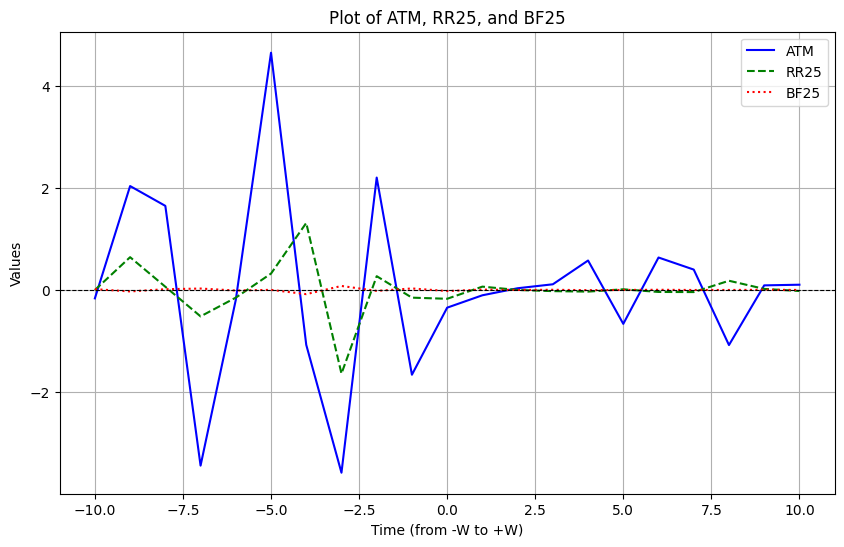

In [369]:
# Plot evt["ATM"], evt["RR25"], evt["BF25"] with an x-axis from -W..+W
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual evt DataFrame)
W = 10  # Define the range for the x-axis (-W to +W)
x = np.linspace(-W, W, len(evt["ATM"]))  # Generate x-axis values

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, evt["ATM"], label="ATM", color="blue", linestyle="-")
plt.plot(x, evt["RR25"], label="RR25", color="green", linestyle="--")
plt.plot(x, evt["BF25"], label="BF25", color="red", linestyle=":")

# Add labels, legend, and title
plt.xlabel("Time (from -W to +W)")
plt.ylabel("Values")
plt.title("Plot of ATM, RR25, and BF25")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Add a horizontal line at y=0
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
